<b>
<p>
<center>
<font size="5">
DATS 6202-11: Machine Learning I
</font>
</center>
</p>

<p>
<center>
<font size="4">
Final Project Report
</font>
</center>
</p>

<p>
<center>
<font size="3">
Benjamin Lee, Polly McKim
</font>
</center>
</p>
</b>

# Medical Appointment No-Shows

# Introduction

The problem that this project attempts to address is why patients decide not to show up to their medical appointments. Whether it be nerves, feelings of [disrespect by the healthcare system](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1466756/), or concerns regarding medical expenses, patient no-shows are becoming increasingly common and cost the healthcare industry billions of dollars. The motivation for this project is to determine whether it's possible to predict no-show appointments through application of the various machine learning models developed in class.

The dataset used in this project contains 110,527 medical appointments with 14 variables related to patient data from Brazil and is sourced from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments). The variables can be found below.

*   PatientId: (int) Identification number of the patient.
*   AppointmentID: (int) Appointment number of the appointment.
*   Gender: (str) Male or Female.
*   DataMarcacaoConsulta: (datetime) The day of the appointment.
*   DataAgendamento: (datetime) The day the patient called to set up the appointment.
*   Age: (int) How old the patient is.
*   Neighbourhood: (str) Where the appointment takes place.
*   Scholarship: (bool) Whether or not the patient possesses a scholarship. This is in reference to Bolsa Família, which is a social welfare program in Brazil that provides financial aid to impoverished Brazilian families.
*   Hipertension: (bool) Whether the patient has been diagnosed with hypertension.
*   Diabetes: (bool) Whether the patient has been diagnosed with diabetes. 
*   Alcoholism: (bool) Whether the patient has been diagnosed with alcoholism.
*   Handcap: (bool) Whether the patient is handicapped.
*   SMS_received: (bool) Whether one or more text messages have been sent to the patient to remind them of the appointment. 
*   No-show: (str) Whether the patient showed up to the appointment.

The target variable of this dataset is "No-show." Various pre-processing steps, including changing the target variable to boolean T/F typing, can be found below.

# Source Citations

The majority of the code written for this project can be attributed to various case studies written by professor Yuxiao Huang. Professor Huang's GitHub page can be found [here](https://github.com/yuxiaohuang/teaching/tree/master/gwu/machine_learning_I/fall_2020/code). Apart from changing the data source, conducting feature engineering, providing additional comments, and analysis of results, the majority of the code is inspired by professor Huang's case studies.

# Notebook Configuration

## Importing Necessary Libraries

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
from itertools import combinations
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import StackingClassifier
from google.colab import drive

## Google Drive

Note the paths for 'abspath_curr,' 'abspath_util_shallow' and 'abspath_model_shallow.' Local folders must be set up using the paths specified.

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/fall_2020/Homework/Final_Project/'

# Get the absolute path of the shallow utilities folder
abspath_util_shallow = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/fall_2020/code/utilities/p2_shallow_learning/'

# Get the absolute path of the shallow models folder
abspath_model_shallow = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/fall_2020/code/models/p2_shallow_learning/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Warning

In [ ]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Matplotlib

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

## TensorFlow

In [ ]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras

## Random Seed

In [ ]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

# Data Preprocessing

Connecting to the utilities folders so professor Huang's code can be used during preprocessing, model training and testing.

Note: Must have the appropriate files from the shallow models and utilities folders. See Professor Huang's [GitHub](https://github.com/yuxiaohuang/teaching/tree/master/gwu/machine_learning_I/fall_2020/code) for these files and place them in the appropriate locations to run successfully.

In [ ]:
# Change working directory to the absolute path of the shallow utilities folder
%cd $abspath_util_shallow

# Import the shallow utitilities
%run pmlm_utilities_shallow.ipynb

/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/fall_2020/code/utilities/p2_shallow_learning


## Loading the data

In this project, we will be using the [medical no-shows dataset](https://www.kaggle.com/joniarroba/noshowappointments). This dataset must be downloaded from Kaggle and placed into the directory called below.

Note: in the submitted zip folder, 'medical_visit.csv' is included. This file can also be pulled from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments), but it must be downloaded and placed in the appropriate folder to run the code successfully.

In [ ]:
# Read in dataset 
df_raw = pd.read_csv(abspath_curr + '/medical_visit.csv', header=0)

# Inspect dataset 
print(df_raw)

           PatientId  AppointmentID Gender          ScheduledDay  \
0       2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1       5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2       4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3       8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4       8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
...              ...            ...    ...                   ...   
110522  2.572134e+12        5651768      F  2016-05-03T09:15:35Z   
110523  3.596266e+12        5650093      F  2016-05-03T07:27:33Z   
110524  1.557663e+13        5630692      F  2016-04-27T16:03:52Z   
110525  9.213493e+13        5630323      F  2016-04-27T15:09:23Z   
110526  3.775115e+14        5629448      F  2016-04-27T13:30:56Z   

              AppointmentDay  Age      Neighbourhood  Scholarship  \
0       2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0   
1       2016-04-29T00:00:00Z   56    JARDIM D

## Getting the name of the target

In [ ]:
target = 'No-show'

## Printing the dimension of the dataset

In [ ]:
# Copy raw data to a new variable
df = df_raw.copy(deep=True)

# Print the dimension of df
pd.DataFrame([[df.shape[0], df.shape[1]]], columns=['# rows', '# columns'])


,# rows,# columns
0,110527,14


# Feature engineering & Preprocessing 

### Printing the dataframe

In [ ]:
print(df.head())

      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0      

### Splitting ScheduledDay to match datetime format

In [ ]:
# Splitting time and date
df["ScheduledDay"] = df["ScheduledDay"].str.replace("T"," ", n = 1)

df["ScheduledDay"] = df["ScheduledDay"].str.replace("Z"," ", n = 1) 

print(df["ScheduledDay"]) 

0         2016-04-29 18:38:08 
1         2016-04-29 16:08:27 
2         2016-04-29 16:19:04 
3         2016-04-29 17:29:31 
4         2016-04-29 16:07:23 
                  ...         
110522    2016-05-03 09:15:35 
110523    2016-05-03 07:27:33 
110524    2016-04-27 16:03:52 
110525    2016-04-27 15:09:23 
110526    2016-04-27 13:30:56 
Name: ScheduledDay, Length: 110527, dtype: object


### Splitting AppointmentDay to match datetime format

In [ ]:
df["AppointmentDay"] = df["AppointmentDay"].str.replace("T"," ", n = 1) 
df["AppointmentDay"] = df["AppointmentDay"].str.replace("Z"," ", n = 1) 

print(df["AppointmentDay"]) 

0         2016-04-29 00:00:00 
1         2016-04-29 00:00:00 
2         2016-04-29 00:00:00 
3         2016-04-29 00:00:00 
4         2016-04-29 00:00:00 
                  ...         
110522    2016-06-07 00:00:00 
110523    2016-06-07 00:00:00 
110524    2016-06-07 00:00:00 
110525    2016-06-07 00:00:00 
110526    2016-06-07 00:00:00 
Name: AppointmentDay, Length: 110527, dtype: object


### Converting the target to boolean values

In [ ]:
df['No-show'].replace("No", 0,inplace=True)
df['No-show'].replace("Yes", 1,inplace=True)

### Removing erroneous ages

It is very unlikely that anyone admitted would be either 0 years old or 115 years old.

In [ ]:
df = df[df.Age>0]
df = df[df.Age <115]

print(df["Age"].value_counts())

1      2273
52     1746
49     1652
53     1651
56     1635
       ... 
97       11
98        6
100       4
102       2
99        1
Name: Age, Length: 101, dtype: int64


### Creating a feature to track the total number of missed appointments

A special note is made here to prevent [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/). We don't want to erroneously use information from outside the training dataset in creation of the models.

In [ ]:
# Track number of previously missed appointments; the -1 prevents data leakage. 
# The number of missed appointments tracked here does NOT include appointments 
# that are or will be missed.
df['Num_App_Missed'] = df.groupby('PatientId')['No-show'].apply(lambda x: x.cumsum()-1)

# The function below accounts for patients that haven't previously missed any 
# appointments; the lambda above will turn zero missed appointments into -1, 
# which wouldn't make any sense.
def num_app_missed(row):
    cell=row["Num_App_Missed"]
    if cell <0:
        return 0
    return cell

df["Num_App_Missed"] = df.apply(lambda row: num_app_missed(row), axis=1)

### Creating a feature to track the total number of appointments

In [ ]:
# The total number of times a patient ID appears in the dataset resolves to the
# total number of appointments they've had.
df["Num_Of_Appts"] = df.apply(lambda row: len(df[df['PatientId'] == row['PatientId']]), axis=1)

print(df.head())

      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29 18:38:08    
1  5.589978e+14        5642503      M  2016-04-29 16:08:27    
2  4.262962e+12        5642549      F  2016-04-29 16:19:04    
3  8.679512e+11        5642828      F  2016-04-29 17:29:31    
4  8.841186e+12        5642494      F  2016-04-29 16:07:23    

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29 00:00:00    62    JARDIM DA PENHA            0             1   
1  2016-04-29 00:00:00    56    JARDIM DA PENHA            0             0   
2  2016-04-29 00:00:00    62      MATA DA PRAIA            0             0   
3  2016-04-29 00:00:00     8  PONTAL DE CAMBURI            0             0   
4  2016-04-29 00:00:00    56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received  No-show  Num_App_Missed  \
0         0           0        0             0        0               0   
1 

### Creating a feature to track on what day of the week an appointment was scheduled.

In [ ]:
# Using pd.day_name() to convert ScheduledDay datetime values to days of the 
# week.
df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'])

df['day_of_week_sche'] = df['ScheduledDay'].dt.day_name()                      

### Creating a feature to track on what day of the week an appointment will be held.

In [ ]:
# Using pd.day_name() to convert AppoinmentDay datetime values to days of the 
# week.
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay'])

df['day_of_week_appt'] = df['AppointmentDay'].dt.day_name() 

### Creating a feature to track the amount of time between the day of the appointment and when the appointment was scheduled.

In [ ]:
# Using pd.daydays() and simple subtraction to find the difference of 
# AppointmentDay and ScheduledDay.
df["time_between_sche_appt"]=df['AppointmentDay']-df['ScheduledDay']

df["time_between_sche_appt"]=df["time_between_sche_appt"].dt.days

type(df["time_between_sche_appt"])

# Converting the time between 'scheduled' and 'appointment' to numeric value.
df[["time_between_sche_appt"]].apply(pd.to_numeric)

# This function accounts for instances where appointments were held on the same
# day they were scheduled.
def fix_time(row):
    cell=row["time_between_sche_appt"]
    if cell <0:
        return 0
    return cell

df["time_between_sche_appt"] = df.apply(lambda row: fix_time(row), axis=1)

print(df["time_between_sche_appt"])

0          0
1          0
2          0
3          0
4          0
          ..
110522    34
110523    34
110524    40
110525    40
110526    40
Name: time_between_sche_appt, Length: 106982, dtype: int64


### Create a feature to track whether the appointment was scheduled on the same day (True/False)

In [ ]:
# This function converts the values in 'time_between_sche_appt' to boolean 
# True/False values.
def same_day_appt(row):
    cell=row["time_between_sche_appt"]
    if cell==0:
        return True
    return False
df["sameday_appt"] = df.apply(lambda row: same_day_appt(row), axis=1)

print(df["sameday_appt"])

0          True
1          True
2          True
3          True
4          True
          ...  
110522    False
110523    False
110524    False
110525    False
110526    False
Name: sameday_appt, Length: 106982, dtype: bool


### Printing the column names

In [ ]:
print(df.columns)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'Num_App_Missed', 'Num_Of_Appts', 'day_of_week_sche',
       'day_of_week_appt', 'time_between_sche_appt', 'sameday_appt'],
      dtype='object')


## Dropping the 'Neighbourhood' feature

After previously running this code, 'Neighbourhood' was found not to be predictive and slowed runtimes significantly. 

In [ ]:
df.drop(["Neighbourhood"], axis = 1, inplace = True)


# Model Building 

## Splitting the data into training and testing (60 - 40 split)

In [ ]:
df_train, df_test = train_test_split(df, 
                                     train_size=0.6, 
                                     random_state=random_seed, 
                                     stratify=df[target])

## Splitting the test data into validation and testing (50 - 50 split)

In [ ]:
df_val, df_test = train_test_split(df_test, 
                                   train_size=0.5, 
                                   random_state=random_seed, 
                                   stratify=df_test[target])

## Resetting the index and printing the dimension of the split sets

### Training set

In [ ]:
# Resetting the index
df_train, df_val, df_test = df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,64189,19


### Validation set

In [ ]:
# Print the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,21396,19


### Testing set

In [ ]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,21397,19


## Handling uncommon features

In [ ]:
# Calling 'common_var_checker'; see the implementation in pmlm_utilities.ipynb
df_common_var = common_var_checker(df_train, df_val, df_test, target)

# Printing df_common_var
df_common_var

,common var
0,Age
1,Alcoholism
2,AppointmentDay
3,AppointmentID
4,Diabetes
5,Gender
6,Handcap
7,Hipertension
8,No-show
9,Num_App_Missed


In [ ]:
# Retrieving the features in the training set, but not in the validation or 
# testing sets
uncommon_feature_train_not_val_test = np.setdiff1d(df_train.columns, df_common_var['common var'])

# Printing the uncommon features
pd.DataFrame(uncommon_feature_train_not_val_test, columns=['uncommon feature'])

,uncommon feature


In [ ]:
# Retrieving the features in the validation set, but not in the training or 
# testing sets
uncommon_feature_val_not_train_test = np.setdiff1d(df_val.columns, df_common_var['common var'])

# Printing the uncommon features
pd.DataFrame(uncommon_feature_val_not_train_test, columns=['uncommon feature'])

,uncommon feature


In [ ]:
# Retrieving the features in the testing set, but not in the training or 
# validation sets
uncommon_feature_test_not_train_val = np.setdiff1d(df_test.columns, df_common_var['common var'])

# Printing the uncommon features
pd.DataFrame(uncommon_feature_test_not_train_val, columns=['uncommon feature'])

,uncommon feature


As seen above, there are no uncommon features in any of the split sets. Yay!

## Handling identifiers

In [ ]:
# Combining df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

In [ ]:
# Calling 'id_checker' on df; see the implementation in pmlm_utilities.ipynb
df_id = id_checker(df)

# Printing the first 5 rows of df_id
df_id.head()

,AppointmentID
0,5735969
1,5636095
2,5623786
3,5649472
4,5722571


In [ ]:
# Removing the identifiers from df_train
df_train.drop(columns=np.intersect1d(df_id.columns, df_train.columns), inplace=True)

# Removing the identifiers from df_val
df_val.drop(columns=np.intersect1d(df_id.columns, df_val.columns), inplace=True)

# Removing the identifiers from df_test
df_test.drop(columns=np.intersect1d(df_id.columns, df_test.columns), inplace=True)

In [ ]:
# Printing the first 5 rows of df_train
df_train.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Num_App_Missed,Num_Of_Appts,day_of_week_sche,day_of_week_appt,time_between_sche_appt,sameday_appt
0,8.441892e+13,M,2016-05-25 07:46:25,2016-06-02,20,0,0,0,0,0,1,1,1,3,Wednesday,Thursday,7,False
1,4.768616e+11,F,2016-04-28 14:29:54,2016-05-20,43,1,0,0,0,0,0,1,9,12,Thursday,Friday,21,False
2,7.776972e+13,M,2016-04-26 14:37:38,2016-05-09,30,1,0,0,0,0,0,0,0,2,Tuesday,Monday,12,False
3,8.159255e+12,F,2016-05-03 06:57:59,2016-05-10,81,0,1,1,0,0,1,0,0,2,Tuesday,Tuesday,6,False
4,8.797948e+13,F,2016-05-20 07:26:45,2016-06-06,36,0,0,0,0,0,0,0,0,4,Friday,Monday,16,False


In [ ]:
# Printing the first 5 rows of df_val
df_val.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Num_App_Missed,Num_Of_Appts,day_of_week_sche,day_of_week_appt,time_between_sche_appt,sameday_appt
0,9.718557e+14,F,2016-04-28 10:32:39,2016-04-29,62,0,1,1,0,0,0,0,0,4,Thursday,Friday,0,True
1,4.167557e+14,M,2016-04-29 08:38:03,2016-04-29,33,0,0,0,0,0,0,0,0,30,Friday,Friday,0,True
2,9.479495e+11,F,2016-06-08 09:31:48,2016-06-08,67,0,1,1,0,0,0,0,0,3,Wednesday,Wednesday,0,True
3,7.682865e+13,M,2016-05-24 15:53:22,2016-05-24,57,0,0,0,0,0,0,0,0,1,Tuesday,Tuesday,0,True
4,3.216433e+14,F,2016-04-27 07:19:51,2016-05-11,57,0,1,0,0,0,0,0,0,3,Wednesday,Wednesday,13,False


In [ ]:
# Printing the first 5 rows of df_test
df_test.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Num_App_Missed,Num_Of_Appts,day_of_week_sche,day_of_week_appt,time_between_sche_appt,sameday_appt
0,5.398735e+13,M,2016-05-02 09:30:21,2016-05-02,68,0,0,0,0,0,0,0,0,1,Monday,Monday,0,True
1,2.373482e+13,F,2016-05-06 13:58:14,2016-06-02,23,0,0,0,0,0,1,1,0,3,Friday,Thursday,26,False
2,5.329155e+12,M,2016-05-25 08:50:57,2016-05-31,11,1,0,0,0,0,1,0,0,1,Wednesday,Tuesday,5,False
3,9.442983e+12,F,2016-05-20 14:37:08,2016-05-25,10,0,0,0,0,0,1,1,0,5,Friday,Wednesday,4,False
4,7.671912e+13,F,2016-05-17 14:40:53,2016-05-17,32,0,0,0,0,0,0,0,0,1,Tuesday,Tuesday,0,True


In [ ]:
# Retrieving the datetime variables
datetime_vars = ["AppointmentDay", "ScheduledDay"]

In [ ]:
# Calling 'datetime_transformer' on df_train
df_train = datetime_transformer(df_train, datetime_vars)

# Printing the first 5 rows of df_train
df_train.head()


,PatientId,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Num_App_Missed,Num_Of_Appts,day_of_week_sche,day_of_week_appt,time_between_sche_appt,sameday_appt,AppointmentDay_year,AppointmentDay_month,AppointmentDay_day,AppointmentDay_hour,AppointmentDay_minute,AppointmentDay_second,ScheduledDay_year,ScheduledDay_month,ScheduledDay_day,ScheduledDay_hour,ScheduledDay_minute,ScheduledDay_second
0,8.441892e+13,M,20,0,0,0,0,0,1,1,1,3,Wednesday,Thursday,7,False,2016,6,2,0,0,0,2016,5,25,7,46,25
1,4.768616e+11,F,43,1,0,0,0,0,0,1,9,12,Thursday,Friday,21,False,2016,5,20,0,0,0,2016,4,28,14,29,54
2,7.776972e+13,M,30,1,0,0,0,0,0,0,0,2,Tuesday,Monday,12,False,2016,5,9,0,0,0,2016,4,26,14,37,38
3,8.159255e+12,F,81,0,1,1,0,0,1,0,0,2,Tuesday,Tuesday,6,False,2016,5,10,0,0,0,2016,5,3,6,57,59
4,8.797948e+13,F,36,0,0,0,0,0,0,0,0,4,Friday,Monday,16,False,2016,6,6,0,0,0,2016,5,20,7,26,45


In [ ]:
# Calling 'datetime_transformer' on df_val
df_val = datetime_transformer(df_val, datetime_vars)

# Printing the first 5 rows of df_val
df_val.head()


,PatientId,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Num_App_Missed,Num_Of_Appts,day_of_week_sche,day_of_week_appt,time_between_sche_appt,sameday_appt,AppointmentDay_year,AppointmentDay_month,AppointmentDay_day,AppointmentDay_hour,AppointmentDay_minute,AppointmentDay_second,ScheduledDay_year,ScheduledDay_month,ScheduledDay_day,ScheduledDay_hour,ScheduledDay_minute,ScheduledDay_second
0,9.718557e+14,F,62,0,1,1,0,0,0,0,0,4,Thursday,Friday,0,True,2016,4,29,0,0,0,2016,4,28,10,32,39
1,4.167557e+14,M,33,0,0,0,0,0,0,0,0,30,Friday,Friday,0,True,2016,4,29,0,0,0,2016,4,29,8,38,3
2,9.479495e+11,F,67,0,1,1,0,0,0,0,0,3,Wednesday,Wednesday,0,True,2016,6,8,0,0,0,2016,6,8,9,31,48
3,7.682865e+13,M,57,0,0,0,0,0,0,0,0,1,Tuesday,Tuesday,0,True,2016,5,24,0,0,0,2016,5,24,15,53,22
4,3.216433e+14,F,57,0,1,0,0,0,0,0,0,3,Wednesday,Wednesday,13,False,2016,5,11,0,0,0,2016,4,27,7,19,51


In [ ]:
# Calling 'datetime_transformer' on df_test
df_test = datetime_transformer(df_test, datetime_vars)

# Printing the first 5 rows of df_test
df_test.head()


,PatientId,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Num_App_Missed,Num_Of_Appts,day_of_week_sche,day_of_week_appt,time_between_sche_appt,sameday_appt,AppointmentDay_year,AppointmentDay_month,AppointmentDay_day,AppointmentDay_hour,AppointmentDay_minute,AppointmentDay_second,ScheduledDay_year,ScheduledDay_month,ScheduledDay_day,ScheduledDay_hour,ScheduledDay_minute,ScheduledDay_second
0,5.398735e+13,M,68,0,0,0,0,0,0,0,0,1,Monday,Monday,0,True,2016,5,2,0,0,0,2016,5,2,9,30,21
1,2.373482e+13,F,23,0,0,0,0,0,1,1,0,3,Friday,Thursday,26,False,2016,6,2,0,0,0,2016,5,6,13,58,14
2,5.329155e+12,M,11,1,0,0,0,0,1,0,0,1,Wednesday,Tuesday,5,False,2016,5,31,0,0,0,2016,5,25,8,50,57
3,9.442983e+12,F,10,0,0,0,0,0,1,1,0,5,Friday,Wednesday,4,False,2016,5,25,0,0,0,2016,5,20,14,37,8
4,7.671912e+13,F,32,0,0,0,0,0,0,0,0,1,Tuesday,Tuesday,0,True,2016,5,17,0,0,0,2016,5,17,14,40,53


## Handling missing data

In [ ]:
# Combining df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

In [ ]:
# Calling 'nan_checker' on df
df_nan = nan_checker(df)

# Printing df_nan
df_nan

,var,proportion,dtype


As seen above, there are no NaN values in the dataset.

In [ ]:
# Printing the unique data type of variables with NaN
pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype'])

,dtype


Because there are no NaN values in the dataset, nothing is returned in the statement above.

In [ ]:
# Retrieving the variables with missing values, finding the proportion of 
# missing values and the data types
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# Printing df_miss
df_miss

,var,proportion,dtype


There are no missing values to account for.

In [ ]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the testing data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

In [ ]:
# Printing the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,64189,28


In [ ]:
# Printing the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,21396,28


In [ ]:
# Printing the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,21397,28


## Removing missing values

In [ ]:
if len(df_miss['var']) > 0:
    # Remove all rows containing missing values from df_train
    df_remove_train = df_train.dropna(subset=np.intersect1d(df_miss['var'], df_train.columns),
                                    inplace=False)

    # Remove all rows containing missing values from df_val
    df_remove_val = df_val.dropna(subset=np.intersect1d(df_miss['var'], df_val.columns),
                                    inplace=False)

    # Remove all rows containing missing values from df_test
    df_remove_test = df_test.dropna(subset=np.intersect1d(df_miss['var'], df_test.columns),
                                inplace=False)


## Imputing missing values

In [ ]:
if len(df_miss['var']) > 0:
    si = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Imputing the variables with missing values in df_train, df_val and df_test 
    df_train[df_miss['var']] = si.fit_transform(df_train[df_miss['var']])
    df_val[df_miss['var']] = si.transform(df_val[df_miss['var']])
    df_test[df_miss['var']] = si.transform(df_test[df_miss['var']])


## Combining the data

In [ ]:
# Combining df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

# Printing the unique data type of variables in df
pd.DataFrame(df.dtypes.unique(), columns=['dtype'])

,dtype
0,float64
1,object
2,int64
3,bool


## Identifying and encoding categorical features

In [ ]:
# Call 'cat_var_checker' on df; see the implementation in pmlm_utilities.ipynb
df_cat = cat_var_checker(df)

# Printing the dataframe
df_cat

,var,nunique
0,day_of_week_sche,6
1,day_of_week_appt,6
2,Gender,2


In [ ]:
# One-hot-encoding the categorical features in the combined data
df = pd.get_dummies(df, columns=np.setdiff1d(df_cat['var'], [target]))

# Printing the first 5 rows of df
df.head()

,PatientId,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Num_App_Missed,Num_Of_Appts,time_between_sche_appt,sameday_appt,AppointmentDay_year,AppointmentDay_month,AppointmentDay_day,AppointmentDay_hour,AppointmentDay_minute,AppointmentDay_second,ScheduledDay_year,ScheduledDay_month,ScheduledDay_day,ScheduledDay_hour,ScheduledDay_minute,ScheduledDay_second,Gender_F,Gender_M,day_of_week_appt_Friday,day_of_week_appt_Monday,day_of_week_appt_Saturday,day_of_week_appt_Thursday,day_of_week_appt_Tuesday,day_of_week_appt_Wednesday,day_of_week_sche_Friday,day_of_week_sche_Monday,day_of_week_sche_Saturday,day_of_week_sche_Thursday,day_of_week_sche_Tuesday,day_of_week_sche_Wednesday
0,8.441892e+13,20,0,0,0,0,0,1,1,1,3,7,False,2016,6,2,0,0,0,2016,5,25,7,46,25,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,4.768616e+11,43,1,0,0,0,0,0,1,9,12,21,False,2016,5,20,0,0,0,2016,4,28,14,29,54,1,0,1,0,0,0,0,0,0,0,0,1,0,0
2,7.776972e+13,30,1,0,0,0,0,0,0,0,2,12,False,2016,5,9,0,0,0,2016,4,26,14,37,38,0,1,0,1,0,0,0,0,0,0,0,0,1,0
3,8.159255e+12,81,0,1,1,0,0,1,0,0,2,6,False,2016,5,10,0,0,0,2016,5,3,6,57,59,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,8.797948e+13,36,0,0,0,0,0,0,0,0,4,16,False,2016,6,6,0,0,0,2016,5,20,7,26,45,1,0,0,1,0,0,0,0,1,0,0,0,0,0


In [ ]:
# The Label Encoder
le = LabelEncoder()

# Encoding the categorical target in the combined data
df[target] = le.fit_transform(df[target])

# Printing the first 5 rows of df
df.head()

# Dropping the 00 values for for the 'AppointmentDay' and  more granular time values for  
# 'ScheduledDay.'
df.drop(["AppointmentDay_hour","AppointmentDay_minute",	"AppointmentDay_second", "ScheduledDay_second", "PatientId"], axis = 1, inplace = True)

## Separating the training, validation and testing data

In [ ]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the testing data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

## Printing the dimensions of the split sets

In [ ]:
# Printing the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,64189,34


In [ ]:
# Printing the dimension of df_val
pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,21396,34


In [ ]:
# Printing the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,21397,34


## Splitting the features and the target

In [ ]:
# Retrieving the feature matrix
X_train = df_train[np.setdiff1d(df_train.columns, [target])].values

X_val = df_val[np.setdiff1d(df_val.columns, [target])].values

X_test = df_test[np.setdiff1d(df_test.columns, [target])].values

# Retrieving the target vector
y_train = df_train[target].values

y_val = df_val[target].values

y_test = df_test[target].values

## Performing min-max normalization

In [ ]:
# The MinMaxScaler
mms = MinMaxScaler()

# Normalizing the training data
X_train = mms.fit_transform(X_train)

# Normalizing the validation data
X_val = mms.transform(X_val)

# Normalizing the testing data
X_test = mms.transform(X_test)

## Imbalance implementation

In [ ]:
ros = RandomOverSampler(random_state=random_seed)

# Transforming X_ros_train and y_ros_train back to dataframes
X_ros_train, y_ros_train = X_train, y_train

'''
from imblearn.over_sampling import SMOTE

# The SMOTE
smote = SMOTE(random_state=random_seed)

# Augment the training data
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)
'''

'\nfrom imblearn.over_sampling import SMOTE\n\n# The SMOTE\nsmote = SMOTE(random_state=random_seed)\n\n# Augment the training data\nX_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)\n'

## Model setup

In [ ]:
models = {'lr': LogisticRegression(class_weight='balanced', random_state=random_seed),
          'dtc': DecisionTreeClassifier(class_weight='balanced', random_state=random_seed),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          'hgbc': HistGradientBoostingClassifier(random_state=random_seed),
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed)}

## Pipelines

In [ ]:
pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

## Getting the pre-defined split cross-validator

In [ ]:
# Specifically, retrieving the:
#   - feature matrix and target velctor in the combined training and validation 
#     data
#   - target vector in the combined training and validation data
#   - PredefinedSplit

X_train_val, y_train_val, ps = get_train_val_ps(X_ros_train, y_ros_train, X_val, y_val)

## GridSearchCV

### Creating the dictionary of parameter grids

In [ ]:
param_grids = {}

### Creating the parameter grids for different models

In [ ]:
# Logistic Regression
#
# The hyperparameters we want to fine-tune are:
#   - C
#   - tol

# The grids for C
C_grids = [10 ** i for i in range(-2, 3)]

# The grids for tol
tol_grids = [10 ** i for i in range(-6, -1)]

# Updating param_grids
param_grids['lr'] = [{'model__C': C_grids,
                      'model__tol': tol_grids}]

In [ ]:
# Decision Tree
# 
# The hyperparameters we want to fine-tune are:
#   - min_samples_split
#   - min_samples_leaf
#
# See details of the meaning of the hyperparameters in 
# sklearn.tree.DecisionTreeClassifier

# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Updating param_grids
param_grids['dtc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

In [ ]:
# Histogram-Based Gradient Boosting Classification Tree
#
# The hyperparameters we want to fine-tune are:
#   - learning_rate
#   - min_samples_leaf
#
# See details of the meaning of the hyperparameters in 
# sklearn.ensemble.HistGradientBoostingClassifier

# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Updating param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]


In [ ]:
# Random Forest
#
# The hyperparameters we want to fine-tune are:
#   - min_samples_split
#   - min_samples_leaf
#
# See details of the meaning of the hyperparameters in 
# sklearn.ensemble.RandomForestClassifier

# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Updating param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

In [ ]:
# Multi-Layer Perceptron Classifier
#
# The hyperparameters we want to fine-tune are:
#   - alpha
#   - learning_rate_init
# See details of the meaning of the hyperparametes in 
# sklearn.neural_network.MLPClassifier

# The grids for solver_grids
solver_grids = ['sgd', 'adam']

# The grids for alpha
alpha_grids = [10 ** i for i in range(-6, -1)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-5, 0)]

# Updating param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

# Training

## Creating the directory for CV results produced by GridSearchCV

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)


In [ ]:
# The list of [best_score_, best_params_, best_estimator_] obtained by 
# GridSearchCV
best_score_params_estimator_gs = []

# Applying GridSearchCV to each model
for acronym in pipes.keys():
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',  
                      n_jobs=1,
                      cv=ps,
                      return_train_score=True)
        
    # Fitting the pipeline
    gs = gs.fit(X_train_val, y_train_val)
    
    # Updating best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sorting cv_results in ascending order of 'rank_test_score' and 
    # 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Retrieving the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Moving the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Writing the cv_results to a CSV file
    cv_results.to_csv(path_or_buf=abspath_curr + './cv_results/GridSearchCV/' + acronym + '.csv', index=False)


# Sorting best_score_params_estimator_gs in descending order based on 
# best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Printing best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])   

,best_score,best_param,best_estimator
0,0.664605,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."
1,0.622813,"{'model__learning_rate': 1, 'model__min_sample...",(HistGradientBoostingClassifier(l2_regularizat...
2,0.610542,"{'model__min_samples_leaf': 1, 'model__min_sam...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
3,0.604523,"{'model__alpha': 1e-05, 'model__learning_rate_...","(MLPClassifier(activation='relu', alpha=1e-05,..."
4,0.584371,"{'model__C': 100, 'model__tol': 1e-06}","(LogisticRegression(C=100, class_weight='balan..."


# Testing

## Examining class distributions from the testing set

This action is performed to find what benchmarks we need to surpass.

In [ ]:
y_test = pd.Series(y_test)

print("Class Distribution:", y_test.value_counts())

# Calculating and printing the percentage of ones
print("Percentage of Ones:", y_test.mean())

# Calculating and printing the percentage of zeros
print("Percentage of Zeros:", 1 - y_test.mean())

# Calculating and printing the null accuracy (for binary classification problems 
# coded as 0 or 1)
print("Null Accuracy:",max(y_test.mean(), 1 - y_test.mean()))

Class Distribution: 0    17061
1     4336
dtype: int64
Percentage of Ones: 0.20264523063980933
Percentage of Zeros: 0.7973547693601907
Null Accuracy: 0.7973547693601907


## Retrieving the precision and best scores for each model

In [ ]:
# The list of [precision, recall, fscore, best_estimator]
precision_recall_fscore_best_estimator = []

for best_score, best_param, best_estimator in best_score_params_estimator_gs:
      # Retrieving the prediction
      y_pred = best_estimator.predict(X_test)

      # Retrieving the precision, recall, fscore, support
      precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)#, average='macro')

      # Retrieving the auc
      # auc = roc_auc_score(y_test, y_pred)

      # Updating 'precision_recall_fscore_auc_best_estimator'
      precision_recall_fscore_best_estimator.append([precision, recall, fscore, best_estimator])

# Returning precision_recall_fscore_best_estimator
#print(pd.DataFrame(precision_recall_fscore_best_estimator, columns=['Precision', 'Recall', 'F1-score', 'Model']))

cat = pd.DataFrame(precision_recall_fscore_best_estimator, columns=['Precision', 'Recall', 'F1-score', 'Model'])
  


In [ ]:
pd.set_option('display.max_columns', None)
print(cat.iloc[:,:4])

                                   Precision  \
0   [0.8751097729268599, 0.4298808432630614]   
1   [0.8364114706656143, 0.5129598662207357]   
2   [0.8873074216000626, 0.3362369337979094]   
3   [0.8261789898592103, 0.7433056325023084]   
4  [0.9146884272997032, 0.32186940544615095]   

                                     Recall  \
0  [0.8177129124904754, 0.5408210332103321]   
1   [0.9317156086982006, 0.282979704797048]   
2  [0.6650254967469668, 0.6676660516605166]   
3  [0.9837055272258367, 0.1856549815498155]   
4  [0.5781607174257077, 0.7878228782287823]   

                                    F1-score  \
0   [0.8454382934884707, 0.4790113369420897]   
1    [0.881495036876837, 0.3647443519619501]   
2  [0.7602519431787725, 0.44724239147226946]   
3   [0.8980869565217391, 0.2971027864919727]   
4  [0.7084934458610164, 0.45702053649073515]   

                                               Model  
0  ((DecisionTreeClassifier(ccp_alpha=0.0, class_...  
1  (HistGradientBoostingClass

## Evaluating the Model (Conclusion)
**NOTE: In the class prediction results above, the following is true:**
-	**Column 2 references no-shows that were positively predicted (patient did not show up; no-show= 1 (“Yes”))**
-	 **Column 1 references non-no-shows (patient did show up; no-show = 0 (“No”))**
-	**The model in row 0 is the random forest model (could not fix labelling as DecisionTreeClassifier); the model in row 2 is the decision tree model.**


Comparing the results of the ML models reveals relatively low accuracies across the board. However, in comparison to the highly imbalanced dataset several of the models show a slight improvement over random guessing. In the context of this project, the ML models should focus on accurately predicting people who are likely to miss an appointment because it is more important to forecast who’s likely to miss an appointment than who’s likely to show up. Thus, “Recall” was considered the most important factor in our evaluation. Evaluation of the results of the ML models reveals the following:
-	The random forest model achieved a relatively high recall of 54% in correctly predicting no-shows 
-	The logistic regression model achieved the highest recall with 78% correctly predicting no-shows. 
-	The decision tree model achieved 67% recall.  

The recall for the non-no-shows for the decision tree model was 66.5%, while logistic regression yielded 58%; both metrics are lower than our target of 80%. The random forest model yielded an 82% recall score for non-no-shows, which is 3% better than our target. Although we need to be mindful of its limitations, for our purposes the random forest model is the best of the bunch. 
 

## Retrieving the best score, estimates and feature importance for Random Forest

In [ ]:
# Retrieving the best_score, best_param and best_estimator of Random Forest 
# obtained by GridSearchCV
best_score_rf, best_param_rf, best_estimator_rf = best_score_params_estimator_gs[0]

# Retrieving the dataframe of feature and importance
df_fi_rf = pd.DataFrame(np.hstack((np.setdiff1d(df.columns, [target]).reshape(-1, 1), best_estimator_rf.named_steps['model'].feature_importances_.reshape(-1, 1))), columns=['Features', 'Importance'])

# Sorting df_fi_rfc in descending order of the importance
df_fi_rf = df_fi_rf.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Printing the first 5 rows of 'df_fi_rf'
df_fi_rf.head()

,Features,Importance
0,time_between_sche_appt,0.159657
1,Num_App_Missed,0.118019
2,Age,0.112272
3,sameday_appt,0.0949383
4,ScheduledDay_minute,0.0942415


## Compiling the results to a CSV

In [ ]:
cat.to_csv ('dataframe.csv', index = False, header=True)

## Plotting the feature importance from Random Forest

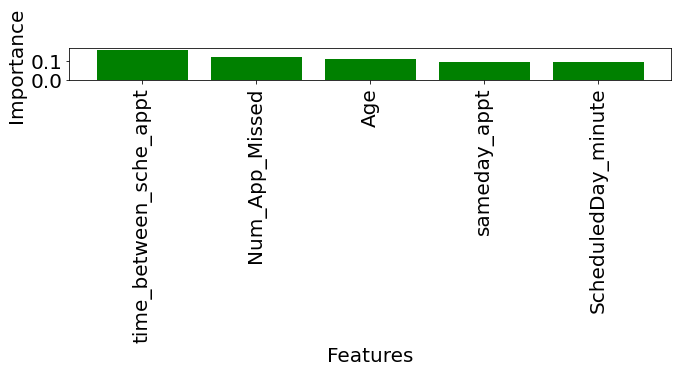

In [ ]:
# Creating a figure
fig = plt.figure(figsize=(10, 5))

# Constructing a bar plot of the top 5 feature importance values
plt.bar(df_fi_rf['Features'][:5], df_fi_rf['Importance'][:5], color='green')

# Initializing the x-axis
plt.xlabel('Features')

plt.xticks(rotation=90)

# Initializing the y-axis
plt.ylabel('Importance')

# Saving and displaying the figure
plt.tight_layout()

plt.show()

# Stacking 

We decided to try out a stacking model to see if we could beat the results of the previous models we created. However, given the results below we will stick with our original models! 

In [ ]:
# Constructing a list containing base estimators 
estimators = [('dtc', DecisionTreeClassifier(class_weight='balanced', random_state=42)),
              ('rfc', RandomForestClassifier(class_weight='balanced', random_state=42)), 
             ('lr', LogisticRegression(class_weight='balanced', random_state=42))]
              

# Initializing the StackingClassifier
sc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42))

# Training the StackingClassifier on the training data
sc.fit(X_train, y_train)

# Retrieving the prediction on the validation data
y_test_pred = sc.predict(X_test)
     

In [ ]:
# Retrieving the precision, recall, f-score and support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred)#, average='macro')

# Printing the precision, recall and f-score
pd.DataFrame([[precision, recall, fscore]], columns=['precision', 'recall', 'f-score'])

,precision,recall,f-score
0,"[0.8314189697547274, 0.6678082191780822]","[0.9715725924623411, 0.22486162361623616]","[0.8960484350505432, 0.33643892339544507]"
